<h3><h3>
<h1><center> Fraud Analytics using Predictive and Social Network Techniques (CS6890) </center></h1>
<h2><center> Clustering Algorithms </center></h2>

<h3>Team members:</h3>
<center>
    <h4>
        <table>
            <tr>
                <th> Name </th>
                <th> Roll Number </th>
            </tr>
            <tr>
                <td> Kritik Agarwal </td>
                <td> CS23MTECH11009 </td>
            </tr>
            <tr>
                <td> Raghavendra Kulkarni </td>
                <td> CS23MTECH11016 </td>
            </tr>
            <tr>
                <td> Arnab Ghosh </td>
                <td> CS23MTECH11025 </td>
            </tr>
            <tr>
                <td> Shagun Sharma </td>
                <td> CS23MTECH14013 </td>
            </tr>
            <tr>
                <td> Trishita Saha </td>
                <td> CS23MTECH14016 </td>
            </tr>
        </table>
    </h4>
</center>

### Import the Required Packages

In [1]:
# Packages for Data Handling
import numpy as np
import pandas as pd

# Packages for Graph Handling
import networkx as nx

# Packages for Convolutional Networks
import torch
import torch.nn.functional as func
from torch_geometric.nn import GCNConv

# Packages for Clustering
from sklearn.cluster import KMeans

# Packages for Plotting and Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Load the Payments data and create the graph

In [2]:
# Create a MultiDiGraph
graph = nx.MultiDiGraph()

# Open the file and assign a file handler
with open('Payments.csv', 'r') as file:

    # Read and ignore the header line
    line = file.readline()

    # For all the following lines
    for line in file.readlines():

        # Split the line into sender, receiver and amount of the payment
        sender, receiver, amount = map(int, line.split(','))

        # Add the payment as an edge between the nodes denoting the sender and the receiver
        graph.add_edge(sender, receiver, weight = amount)

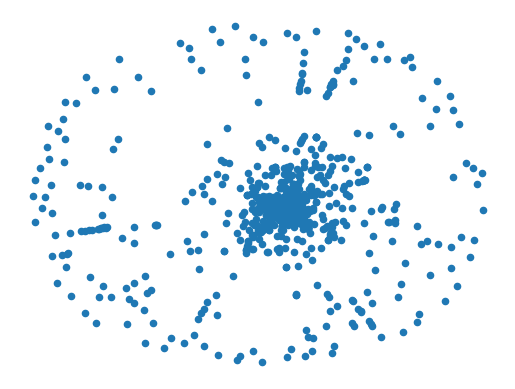

In [3]:
# Draw the network nodes excluding the edges
nx.draw_networkx_nodes(graph, pos=nx.spring_layout(graph), node_size = 20)  # Use desired layout

# Neglect the X and Y axes
plt.axis('off')

# Save and display the graph
plt.savefig('Graph Display.png')
plt.show()

### Node2Vec Clustering

In [4]:
# A function to generate a random walk from a given starting node
def random_walk(graph, start_node, walk_length):
    
    # Initialize the list
    walk = [start_node]
    
    # For every next node
    for _ in range(walk_length-1):
        
        # Gather the neighbors of the current node
        neighbors = list(graph.neighbors(walk[-1]))
        
        # Stop at the node with no out neighbors
        if len(neighbors) == 0:
            break
        
        # Add the randomly chosen neighbor the walk list
        walk.append(np.random.choice(neighbors))
    
    # Return the walk
    return [str(node) for node in walk]

# A function to generate random walks from every starting node
def generate_random_walks(graph, num_walks, walk_length):
    
    # Initialize a list for storing the walks
    walks = []

    # For every walk
    for _ in range(num_walks):

        # Iterate through every node and generate a walk from that node
        for node in graph.nodes():
            walks.append(random_walk(graph, node, walk_length))
    
    # Return the list of walks
    return walks

# A function to calculate the sigmoid activation value
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# A function to implement Skip-gram model for learning the embeddings
def train_node2vec_embeddings(walks, dimensions=128, window_size=10, learning_rate=0.025, num_epochs=1):
    
    # Initialize embeddings randomly
    embeddings = {node: np.random.uniform(-0.5/dimensions, 0.5/dimensions, dimensions) for node in set(sum(walks, []))}
    
    # For every epoch
    for _ in range(num_epochs):

        # For every walk in an epoch
        for walk in walks:

            # For every center, context node pair
            for i, center_node in enumerate(walk):
                for j, context_node in enumerate(walk[max(i - window_size, 0):i + window_size]):
                    
                    if center_node != context_node:
                        
                        # Calculate the difference score of the embeddings
                        center_embedding = embeddings[center_node]
                        context_embedding = embeddings[context_node]
                        score = np.dot(center_embedding, context_embedding)
                        predicted = sigmoid(score)
                        error = predicted - 1.0
                        
                        # Update the embeddings using gradient descent
                        embeddings[center_node] -= learning_rate * error * context_embedding
                        embeddings[context_node] -= learning_rate * error * center_embedding
    
    # Return the embeddings of the nodes
    return embeddings

# A function to identify clusters using KMeans
def identify_clusters(embeddings, num_clusters):
    X = np.array(list(embeddings.values()))
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    return kmeans.labels_

In [5]:
# Initialize the required variables and generate random walks
num_walks = 10
walk_length = 80
walks = generate_random_walks(graph, num_walks, walk_length)

# Train the Node2Vec embeddings
dimensions = 128
window_size = 10
learning_rate = 0.25
num_epochs = 10
embeddings = train_node2vec_embeddings(walks, dimensions, window_size, learning_rate, num_epochs)

# Identify the clusters using KMeans
num_clusters = 2  # Adjust the number of clusters as needed
labels = identify_clusters(embeddings, num_clusters)

c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [6]:
# Convert the embeddings into numpy arrays
vectors = list(embeddings.values())
vectors = np.asarray(vectors)

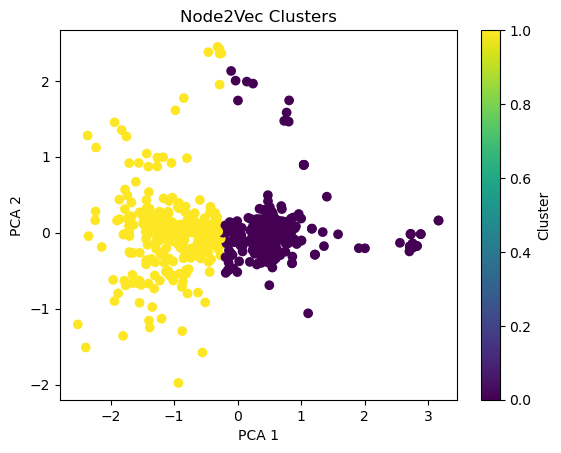

In [7]:
# Perform PCA on the node embeddings
pca = PCA(n_components=2)
result2d = pca.fit_transform(vectors)

# Create a scatter plot of the projection
plt.scatter(result2d[:, 0], result2d[:, 1], c=labels)
plt.title('Node2Vec Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.savefig('Node2Vec.png')
plt.show()

### Spectral Clustering

In [18]:
# A function to perform spectral clustering
def spectral_clustering(A, k):
    
    # Calculate the Degree matrix and Laplacian matrix
    D = np.sum(A, axis=0)
    L = D - A

    # Solve for eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(L)
    eigenvectors = np.abs(eigenvectors)

    # Sort eigenvalues (ascending order) and get corresponding eigenvectors
    sorted_idx = np.argsort(eigenvalues)
    low_dimension_embedding = eigenvectors[:, sorted_idx[:32]]

    # Apply k-means clustering on the low-dimensional embedding
    kmeans = KMeans(n_clusters=k, random_state = 42).fit(low_dimension_embedding)
    cluster_labels = kmeans.labels_

    # Return the cluster labels and the embeddings
    return cluster_labels, low_dimension_embedding

In [19]:
# Construct the adjacency matrix for the graph
A = nx.adjacency_matrix(graph).todense()

# Call the spectral clustering on the adjacency matrix
labels, embeddings = spectral_clustering(A, k = 2)

c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


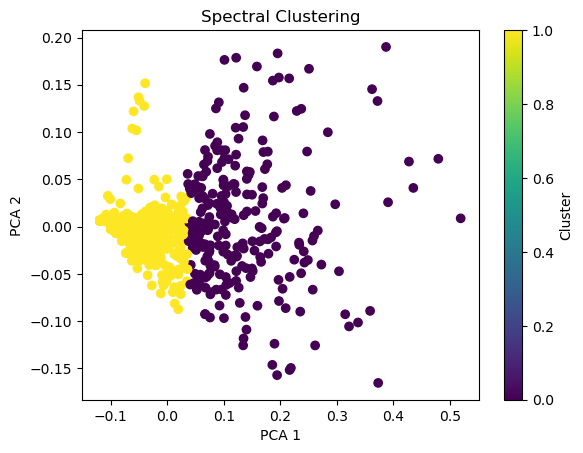

In [20]:
# Perform PCA on the node embeddings
pca = PCA(n_components=2)
result2d = pca.fit_transform(embeddings)

# Create a scatter plot of the projection
plt.scatter(result2d[:, 0], result2d[:, 1], c=labels)
plt.title('Spectral Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.savefig('Spectral.png')
plt.show()

### GCN Clustering

In [11]:
# Read the graph data and compress multi-edges into a single edge
data = pd.read_csv('Payments.csv')
data = data.groupby(['Sender', 'Receiver']).sum('Amount')
data = data.reset_index()

In [12]:
# Create a directed graph with the data
graph = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', edge_attr='Amount', create_using = nx.DiGraph())

In [13]:
# Reindex nodes for compatibility
node_mapping_reindexed = {old_id: i for i, old_id in enumerate(graph.nodes)}
graph_relabelled = nx.relabel_nodes(graph, node_mapping_reindexed)

# Create edge index and edge weight tensors
edge_index_tensor = torch.tensor(list(graph_relabelled.edges)).t()
edge_weight_tensor = torch.tensor([graph_relabelled[edge[0]][edge[1]]['Amount'] for edge in graph_relabelled.edges], dtype=torch.float)

In [14]:
# Define the GCN Class to train the model
class GraphConvolutionalNetwork(torch.nn.Module):
    def __init__(self, num_nodes, hidden_dim1, hidden_dim2, embed_dim):
        super(GraphConvolutionalNetwork, self).__init__()
        self.conv1 = GCNConv(num_nodes, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, embed_dim)

    # Forward propagation
    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = func.relu(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = func.relu(x)

        x = self.conv3(x, edge_index, edge_weight)
        return x

# A function to calculate the mean of the distance matrix
def mean_distance_loss_function(embeddings):
    distance_matrix = torch.cdist(embeddings, embeddings, p=2)
    return torch.mean(distance_matrix)

In [15]:
# Initialize the required variables
num_nodes = len(graph.nodes)
features = torch.eye(num_nodes)
hidden_dim1 = 256
hidden_dim2 = 128
embed_dim = 3
epochs = 500

# Initialize the GCN model and set an optimizer
model = GraphConvolutionalNetwork(num_nodes, hidden_dim1, hidden_dim2, embed_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the GCN model
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(features, edge_index_tensor, edge_weight_tensor)
    loss = mean_distance_loss_function(output)
    # Print loss every 'print_every' epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}")
    loss.backward()
    optimizer.step()

Epoch [100/500] Loss: 2.1541450023651123
Epoch [200/500] Loss: 0.8726080060005188
Epoch [300/500] Loss: 0.540097713470459
Epoch [400/500] Loss: 0.4949667155742645
Epoch [500/500] Loss: 0.4295853078365326


In [16]:
# Perform the Clustering using K-Means
model.eval()
node_embeddings = model(features, edge_index_tensor, edge_weight_tensor).detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit(node_embeddings)
cluster_labels = kmeans.labels_

c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ragha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


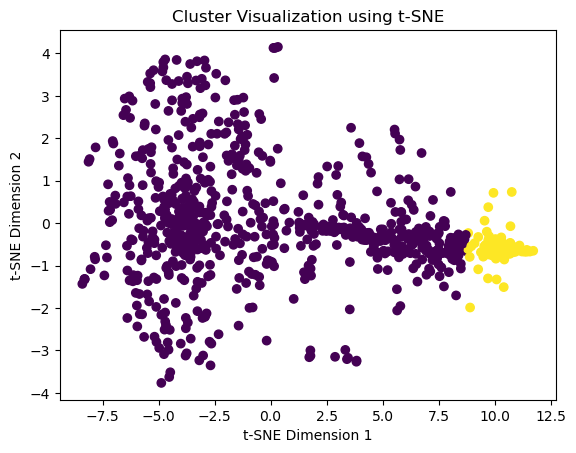

In [24]:
# Visualize clusters using t-SNE
tsne = TSNE(n_components=2, perplexity=200)
reduced_embeddings = tsne.fit_transform(node_embeddings)

# Project the embeddings onto a plot
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Cluster Visualization using t-SNE")
plt.savefig('GCN.png')
plt.show()